# Setup
First, we need to import some things and set API keys.

In [2]:
import sys
sys.path.append("../")
from dsrag.knowledge_base import KnowledgeBase
from dsrag.document_parsing import extract_text_from_pdf
from dsrag.rse import get_best_segments
import cohere
import os
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

# set API keys
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["ANTHROPIC_API_KEY"] = ""
os.environ["CO_API_KEY"] = ""

#### Load in document and add to KB
We'll go ahead and add the document to a dsRAG knowledge base, which will take care of semantic sectioning and chunking. Semantic sectioning is the process of breaking a document into semantically cohesive sections. These sections are then broken up into smaller chunks if needed. Each section is given a descriptive title, which we'll use later in the ranking process.

In [3]:
# load in some data
#file_path = "../tests/data/levels_of_agi.pdf"
file_path = "../tests/data/nike_2023_annual_report.txt"
doc_id = os.path.basename(file_path).split(".")[0] # grab the file name without the extension so we can use it as the doc_id

# kb_id = "levels_of_agi"
kb_id = "nike_10k"

if file_path.endswith(".pdf"):
    document_text = extract_text_from_pdf(file_path)
else:
    with open(file_path, "r") as f:
        document_text = f.read()

print (document_text[:1000])

FORM 10-K FORM 10-KUNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K 
(Mark One)
☑ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
FOR THE FISCAL YEAR ENDED MAY 31, 2023 
OR
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
FOR THE TRANSITION PERIOD FROM TO .
Commission File No. 1-10635 
NIKE, Inc. 
(Exact name of Registrant as specified in its charter)
Oregon 93-0584541
(State or other jurisdiction of incorporation) (IRS Employer Identification No.)
One Bowerman Drive, Beaverton, Oregon 97005-6453 
(Address of principal executive offices and zip code)
(503) 671-6453 
(Registrant's telephone number, including area code)
SECURITIES REGISTERED PURSUANT TO SECTION 12(B) OF THE ACT:
Class B Common Stock NKE New York Stock Exchange
(Title of each class) (Trading symbol) (Name of each exchange on which registered)
SECURITIES REGISTERED PURSUANT TO SECTION 12(G) OF THE ACT:
NONE
Indica

In [ ]:
# NOTE: the two sample KBs used in this notebook already exist in the example_kb_data directory, so you don't need to run this cell unless you want to create a new KB

# add to knowledge base
kb = KnowledgeBase(kb_id=kb_id, exists_ok=False, storage_directory='example_kb_data') # create a new knowledge base
kb.add_document(doc_id=doc_id, text=document_text, auto_context=False, semantic_sectioning=True) # add the document to the knowledge base

# View chunks and sections

In [13]:
# load in chunks
kb = KnowledgeBase(kb_id=kb_id, exists_ok=True, storage_directory='example_kb_data')

num_chunks = len(kb.chunk_db.data[doc_id])
print (num_chunks)

chunks = []
for i in range(num_chunks):
    chunk = {
        "chunk_header": kb.chunk_db.get_chunk_header(doc_id, i),
        "section_title": kb.chunk_db.get_section_title(doc_id, i),
        "chunk_text": kb.chunk_db.get_chunk_text(doc_id, i),
    }

    chunks.append(chunk)

chunks[0]

493


{'chunk_header': '',
 'section_title': 'Form 10-K Cover Page and Company Information',
 'chunk_text': "FORM 10-K FORM 10-KUNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\nFORM 10-K \n(Mark One)\n☑ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934\nFOR THE FISCAL YEAR ENDED MAY 31, 2023 \nOR\n☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934\nFOR THE TRANSITION PERIOD FROM TO .\nCommission File No. 1-10635 \nNIKE, Inc. \n(Exact name of Registrant as specified in its charter)\nOregon 93-0584541\n(State or other jurisdiction of incorporation) (IRS Employer Identification No.)\nOne Bowerman Drive, Beaverton, Oregon 97005-6453 \n(Address of principal executive offices and zip code)\n(503) 671-6453 \n(Registrant's telephone number, including area code)\nSECURITIES REGISTERED PURSUANT TO SECTION 12(B) OF THE ACT:"}

Now let's print out all of the sections that the semantic sectioning process identified.

In [14]:
# print all section titles
unique_section_titles = []
for i in range(num_chunks):
    section_title = chunks[i]["section_title"]
    if section_title not in unique_section_titles:
        print (section_title)
        unique_section_titles.append(section_title)

Form 10-K Cover Page and Company Information
Table of Contents
Business Overview
Product Offerings
Sales and Marketing Strategy
Market Segments and Geographic Operations
Significant Customer Information
Product Research, Design and Development
Manufacturing and Supply Chain Overview
International Operations and Trade Challenges
Competition in the Athletic Footwear and Apparel Industry
Intellectual Property Rights and Protection
Human Capital Resources and Company Culture
Employee Base and Labor Relations
Diversity, Equity, and Inclusion Initiatives
Compensation and Benefits Overview
Available Information and Websites
Information About Executive Officers
Forward-Looking Statements and Risk Factors Introduction
Global Economic Conditions and Their Impact on NIKE's Business
Intense Competition in the Athletic Footwear, Apparel, and Equipment Industry
Currency Exchange Rate Fluctuations and Their Effects on Financial Results
Financial Health of Wholesale Customers and Its Impact on NIKE
Cl

# Add contextual chunk headers and measure impact
We'll use the Cohere Rerank API for rank our chunks. Normally, we'd start with a vector and/or keyword search to narrow down the list of candidates, but since we're just dealing with a single document here we can just send all chunks directly to the reranker, keeping things a bit simpler.

In [6]:
def transform(x):
    """
    Transformation function to map the absolute relevance value to a value that is more uniformly distributed between 0 and 1
    - This is critical for the new version of RSE to work properly, because it utilizes the absolute relevance values to calculate the similarity scores
    - The relevance values given by the Cohere reranker tend to be very close to 0 or 1. This beta function used here helps to spread out the values more uniformly.
    """
    a, b = 0.4, 0.4  # These can be adjusted to change the distribution shape
    return beta.cdf(x, a, b)

def rerank_documents(query: str, documents: list) -> list:
    """
    Use Cohere Rerank API to rerank the search results
    """
    model = "rerank-english-v3.0"
    client = cohere.Client(api_key=os.environ["CO_API_KEY"])
    decay_rate = 30

    reranked_results = client.rerank(model=model, query=query, documents=documents)
    results = reranked_results.results
    reranked_indices = [result.index for result in results]
    reranked_similarity_scores = [result.relevance_score for result in results] # in order of reranked_indices
    
    # convert back to order of original documents and calculate the chunk values
    similarity_scores = [0] * len(documents)
    chunk_values = [0] * len(documents)
    for i, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(reranked_similarity_scores[i])
        similarity_scores[index] = absolute_relevance_value
        v = np.exp(-i/decay_rate)*absolute_relevance_value # decay the relevance value based on the rank
        chunk_values[index] = v

    return similarity_scores, chunk_values

#### Contextual chunk headers
We'll add both a document context and a section context to each chunk.

In [23]:
if kb_id == "levels_of_agi":
    document_context = "Document: Levels of AGI"
elif kb_id == "nike_10k":
    document_context = "Document: Nike 10-K FY2023"
else:
    document_context = "Document: Unknown"

documents = []
documents_no_context = [] # baseline for comparison
for i in range(num_chunks):
    section_context = f"Section: {chunks[i]['section_title']}"
    chunk_text = chunks[i]["chunk_text"]
    document = f"{document_context}\n{section_context}\n\n{chunk_text}"
    documents.append(document)
    documents_no_context.append(chunk_text)

chunk_index_to_inspect = 226
query = "Nike operating segment results"
print (documents[chunk_index_to_inspect])

Document: Nike 10-K FY2023
Section: Operating Segments Overview

Asia Pacific & Latin America(2) 6,431  5,955  8 %  17 %  5,343  11 %  16 %
Global Brand Divisions(3) 58  102  -43 %  -43 %  25  308 %  302 %
TOTAL NIKE BRAND $ 48,763 $ 44,436  10 %  16 % $ 42,293  5 %  6 %
Converse  2,427  2,346  3 %  8 %  2,205  6 %  7 %
Corporate(4) 27  (72)  —  —  40  —  — 
TOTAL NIKE, INC. REVENUES $ 51,217 $ 46,710  10 %  16 % $ 44,538  5 %  6 %
(1) The percent change excluding currency changes represents a non-GAAP financial measure. For further information, see "Use of Non-GAAP Financial 
Measures".
(2) For additional information on the transition of our NIKE Brand businesses within our CASA territory to a third-party distributor, see Note 18 —


Prepending document and section title information adds important context to the chunk. Let's see how much of a difference it makes in the relevance ranking.

In [24]:
# run this chunk through the Cohere Rerank API with and without the context header
similarity_scores, chunk_values = rerank_documents(query, [documents[chunk_index_to_inspect], documents_no_context[chunk_index_to_inspect]])

print (f"Similarity with contextual chunk header: {similarity_scores[0]}")
print (f"Similarity without contextual chunk header: {similarity_scores[1]}")

unknown field: parameter model is not a valid field


Similarity with contextual chunk header: 0.9478511693486031
Similarity without contextual chunk header: 0.7076549370696927


That's a pretty substantial difference.

#### Run queries and visualize results

unknown field: parameter model is not a valid field


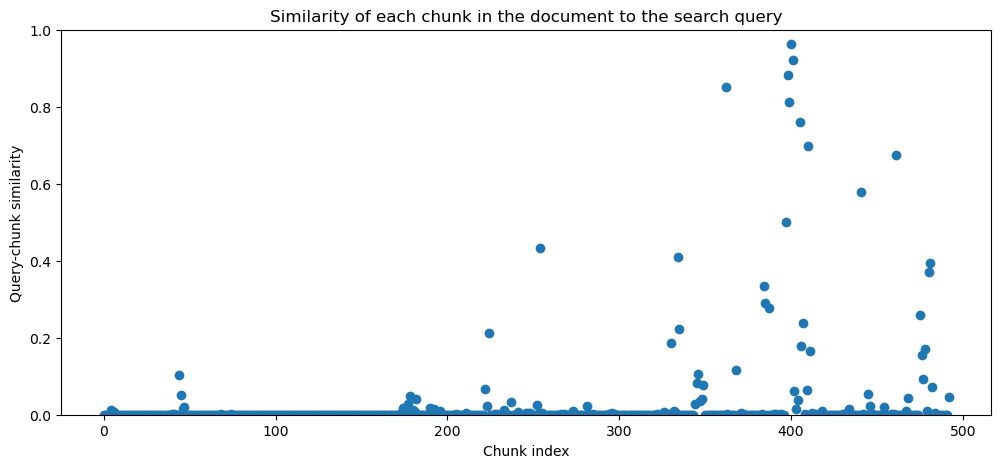

In [11]:
# Levels of AGI
#query = "Principles for defining levels of AGI"
#query = "Levels of AGI paper references"
#query = "CoALA paper references"
#query = "What are the levels of AGI?"
#query = "What is Autonomy Level 3"
#query = "Levels of AGI Introduction section"
#query = "Use of existing AI benchmarks like Big-bench and HELM"
#query = "How does autonomy factor into AGI?"
#query = "What are the levels of AGI?"

# Nike 10-K
#query = "Nike cash flow statement"
#query = "Nike revenue growth"
#query = "2023 Nike North America segment results"
#query = "Nike board of directors"
#query = "Nike supply chain challenges"
query = "Nike stock-based compensation expenses"
#query = "Nike consolidated balance sheet"
#query = "What is the mission of Nike?"
#query = "Nike CEO tenure"

similarity_scores, chunk_values = rerank_documents(query, documents)

plt.figure(figsize=(12, 5))
plt.title(f"Similarity of each chunk in the document to the search query")
plt.ylim(0, 1)
plt.xlabel("Chunk index")
plt.ylabel("Query-chunk similarity")
plt.scatter(range(len(chunk_values)), chunk_values)

#### How to interpret the chunk relevance plot above
In the plot above, the x-axis represents the chunk index. The first chunk in the document has index 0, the next chunk has index 1, etc. The y-axis represents the relevance of each chunk to the query. Viewing it this way lets us see how relevant chunks tend to be clustered in one or more sections of a document. 

Note: the relevance values in this plot are actually a combination of the raw relevance value and the relevance ranks. An exponential decay function is applied to the ranks, and that is then multiplied by the raw relevance value. Using this combination provides a more robust measure of relevance than using just one or the other, at least in most cases.

#### What can we do with these clusters of relevant chunks?
The core idea is that clusters of relevant chunks, in their original contiguous form, provide much better context to the LLM than individual chunks can. Now for the hard part: how do we actually identify these clusters?

If we can calculate chunk values in such a way that the value of a segment is just the sum of the values of its constituent chunks, then finding the optimal segment is a version of the maximum subarray problem, for which a solution can be found relatively easily. How do we define chunk values in such a way? We'll start with the idea that highly relevant chunks are good, and irrelevant chunks are bad. We already have a good measure of chunk relevance, on a scale of 0-1, so all we need to do is subtract a constant threshold value from it. This will turn the chunk value of irrelevant chunks to a negative number, while keeping the values of relevant chunks positive. We call this the `irrelevant_chunk_penalty`. A value around 0.2 seems to work well empirically.

# Relevant segment deep dive

In [12]:
# be sure you're using the Nike 10-K KB for these next few cells, as we'll be focusing on a single example query for that document
query = "Nike stock-based compensation expenses"
similarity_scores, chunk_values = rerank_documents(query, documents)

irrelevant_chunk_penalty = 0.2
all_relevance_values = [[v - irrelevant_chunk_penalty for v in chunk_values]]
document_splits = []
max_length = 30
overall_max_length = 50
minimum_value = 0.5

# get_best_segments solves a constrained version of the maximum sum subarray problem
best_segments, scores = get_best_segments(all_relevance_values, document_splits, max_length, overall_max_length, minimum_value)

print (best_segments)
print (scores)
print ()

# print the best segments
for segment_start, segment_end in best_segments:
    # concatenate the text of the chunks in the segment
    segment_text = f"[{document_context}]\n"
    for i in range(segment_start, segment_end):
        chunk_text = chunks[i]["chunk_text"]
        segment_text += chunk_text + "\n"

    print (segment_text)
    print ("\n---\n")

unknown field: parameter model is not a valid field


[(397, 411), (362, 363)]
[3.3367363697189947, 0.6520419700343456]

[Document: Nike 10-K FY2023]
NOTE 9 — COMMON STOCK AND STOCK-BASED COMPENSATION
COMMON STOCK
The authorized number of shares of Class A Common Stock, no par value, and Class B Common Stock, no par value, are 400 
million and 2,400 million, respectively. Each share of Class A Common Stock is convertible into one share of Class B Common 
Stock. Voting rights of Class B Common Stock are limited in certain circumstances with respect to the election of directors. There 
are no differences in the dividend and liquidation preferences or participation rights of the holders of Class A and Class B 
Common Stock. From time to time, the Company's Board of Directors authorizes share repurchase programs for the repurchase 
of Class B Common Stock. The value of repurchased shares is deducted from Total shareholders' equity through allocation to 
Capital in excess of stated value and Retained earnings.
NIKE, INC.      74STOCK-BASED COM

Let's zoom in to the best segment and see what the chunk relevance values look like. 

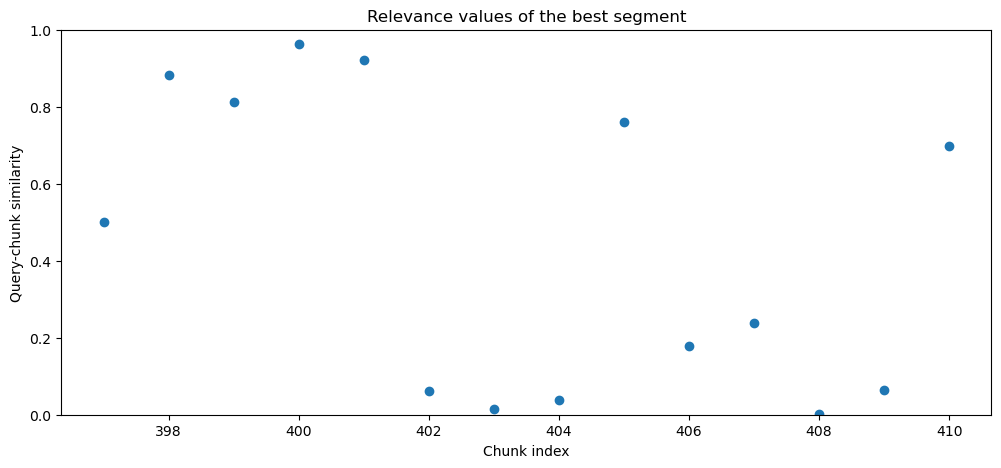

In [9]:
# plot the relevance values of the best segment
best_segment_chunk_indexes = list(range(best_segments[0][0], best_segments[0][1]))
best_segment_chunk_values = chunk_values[best_segments[0][0]:best_segments[0][1]]

plt.figure(figsize=(12, 5))
plt.title(f"Relevance values of the best segment")
plt.ylim(0, 1)
plt.xlabel("Chunk index")
plt.ylabel("Query-chunk similarity")
plt.scatter(best_segment_chunk_indexes, best_segment_chunk_values)

You'll notice that a few of the chunks (especially 402-404) aren't particularly relevant, but they're surrounded by relevant chunks, so we include them in the segment for continuity.

In [10]:
# print the individual chunks in the best segment - annotated with their chunk indexes and relevance values
for chunk_index in best_segment_chunk_indexes:
    chunk_text = chunks[chunk_index]["chunk_text"]
    chunk_value = chunk_values[chunk_index]
    print (f"Chunk index: {chunk_index} - Relevance value: {chunk_value}")
    print (chunk_text)
    print ("\n---\n")

Chunk index: 397 - Relevance value: 0.500182327144306
NOTE 9 — COMMON STOCK AND STOCK-BASED COMPENSATION
COMMON STOCK
The authorized number of shares of Class A Common Stock, no par value, and Class B Common Stock, no par value, are 400 
million and 2,400 million, respectively. Each share of Class A Common Stock is convertible into one share of Class B Common 
Stock. Voting rights of Class B Common Stock are limited in certain circumstances with respect to the election of directors. There 
are no differences in the dividend and liquidation preferences or participation rights of the holders of Class A and Class B 
Common Stock. From time to time, the Company's Board of Directors authorizes share repurchase programs for the repurchase 
of Class B Common Stock. The value of repurchased shares is deducted from Total shareholders' equity through allocation to 
Capital in excess of stated value and Retained earnings.

---

Chunk index: 398 - Relevance value: 0.8813457575814403
NIKE, INC.    

Looking at the content of each of these chunks, it's clear that chunks 397-401 are highly relevant, as expected. But looking closely at chunks 402-404, we can see they're actually also relevant, despite being marked as irrelevant by our ranking model. This is a common theme: chunks that are marked as not relevant, but are sandwiched between highly relevant chunks, are oftentimes quite relevant. In this case, the chunks were about stock option valuation, so while they weren't explicitly discussing stock-based compensation expenses (which is what we were searching for), in the context of the surrounding chunks it's clear that they are actually relevant.